In [4]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import copy
import os

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

load data

In [5]:
tadpole = pd.read_csv("TADPOLE_D1_D2.csv", low_memory=False)
tadpole_desc = pd.read_csv("TADPOLE_D1_D2_Dict.csv", low_memory=False)

set data prep variables

In [6]:
col_thresh = 0.4 # maximum allowed missingness percentage when filtering features
row_thresh = 0.05 # maximum allowed missingness percentage when filtering samples
longest_valid_gap = 24 # longest allowed gap between visits when finding longest patient sequences

make viscodes numerical

In [7]:
tadpole['VISCODE'] = tadpole['VISCODE'].apply(lambda x: 0 if x=='bl' else int(x.split('m')[1]))

modality mux

In [8]:
modalities = {'vis_info': [0,3],
            'main_cognitive_tests': [21, 42],
            'mri_roi': [486, 832],
            'mri_vols': [47, 54],
            'fdg_pet_roi': [838, 1172],
            'av45_pet_roi': [1174, 1412],
            'av1451_pet_roi': [1416, 1656],
            'dti_roi': [1667, 1895],
            'csf_bio': [1903, 1906],
            'other': [11, 21]}
def get_modes(df, col_dict):
    # Initialize an empty list to store the filtered columns and new MultiIndex labels
    filtered_columns = []
    new_multiindex_labels = []

    # Iterate over the dictionary to filter columns
    for top_level, (start_col, end_col) in col_dict.items():
        # Find the columns between start_col and end_col (inclusive)
        selected_columns = df.iloc[:, start_col:end_col].columns
        
        # Append these columns to the list
        filtered_columns.append(selected_columns)
        
        # Create MultiIndex labels for the selected columns (top-level from dict, sub-level from column names)
        new_multiindex_labels.extend([(top_level, col) for col in selected_columns])

    # Flatten the list of columns
    filtered_columns = [col for sublist in filtered_columns for col in sublist]
    
    # Create a new DataFrame with the filtered columns
    df_filtered = df[filtered_columns].copy()
    
    # Set the MultiIndex on the columns
    df_filtered.columns = pd.MultiIndex.from_tuples(new_multiindex_labels)
    
    return df_filtered

tadpole_modes = get_modes(tadpole, modalities)

filter out sparse features

In [9]:
for mode in modalities:
    if mode == 'other':
        mode_nan_fill = tadpole_modes[mode].replace('/', 
                                '', regex=True).replace(' ',
                                '', regex=True).replace('',
                                np.nan, regex=True).replace(-4,
                                np.nan, regex=True)
    elif mode == 'csf_bio':
        mode_nan_fill = tadpole_modes[mode].replace(r'^\s*$',
                                np.nan, regex=True).replace('<',
                                '', regex=True).replace('>', 
                                '', regex=True).replace(-4,
                                np.nan, regex=True)
        
    else:
        mode_nan_fill = tadpole_modes[mode].replace('', 
                                np.nan, regex=True).replace(' ',
                                np.nan, regex=True).replace(-4,
                                np.nan, regex=True)
    tadpole_modes[mode] = mode_nan_fill

tadpole_modes['other', 'DX'] = tadpole['DX']

In [10]:
good_columns = [col for col in tadpole_modes.columns if tadpole_modes[col].isnull().mean() <= col_thresh]
tadpole_filtered_cols = tadpole_modes[good_columns]
print(f'For missingness threshold of {100*col_thresh}% there are {len(good_columns)-3} dense feature columns out of 1427 = {round(100*(len(good_columns)-3) / 1427, 2)}% of columns retained')

For missingness threshold of 40.0% there are 332 dense feature columns out of 1427 = 23.27% of columns retained


filter out sparse rows

In [11]:
good_rows = [row for row in tadpole_filtered_cols.index if tadpole_filtered_cols.iloc[row].isnull().mean() <= row_thresh]
total_cohort = tadpole_filtered_cols.iloc[good_rows]
total_cohort

vis_info                     main_cognitive_tests                      \
           RID        PTID VISCODE                CDRSB ADAS11 ADAS13  MMSE   
0            2  011_S_0002       0                  0.0  10.67  18.67  28.0   
1            3  011_S_0003       0                  4.5  22.00  31.00  20.0   
2            3  011_S_0003       6                  6.0  19.00  30.00  24.0   
3            3  011_S_0003      12                  3.5  24.00  35.00  17.0   
4            3  011_S_0003      24                  8.0  25.67  37.67  19.0   
...        ...         ...     ...                  ...    ...    ...   ...   
12386     4446  135_S_4446      48                  0.5   8.00  12.00  29.0   
12408     4488  007_S_4488      48                  0.0   5.00   8.00  30.0   
12428     4513  041_S_4513      48                  0.0   2.00   2.00  30.0   
12482     4164  023_S_4164      48                  0.0   7.00  16.00  29.0   
12484     4115  023_S_4115      48                  1.0   9.00  18.00  30.0   

                                                       ...   mri_vols  \
      RAVLT_immediate RAVLT_learning RAVLT_forgetting  ... WholeBrain   
0                44.0            4.0              6.0  ...  1229740.0   
1                22.0            1.0              4.0  ...  1129830.0   
2                19.0            2.0              6.0  ...  1100060.0   
3                31.0            2.0              7.0  ...  1095640.0   
4                23.0            1.0              5.0  ...  1088560.0   
...               ...            ...              ...  ...        ...   
12386            51.0            5.0              0.0  ...   971901.0   
12408            56.0            1.0              0.0  ...  1119990.0   
12428            64.0            8.0              3.0  ...  1019350.0   
12482            42.0            7.0              4.0  ...        NaN   
12484            39.0            6.0              6.0  ...  1110990.0   

                 other                                                     \
             ICV   AGE PTGENDER PTEDUCAT       PTETHCAT PTRACCAT  PTMARRY   
0      1984660.0  74.3     Male       16  NotHispLatino    White  Married   
1      1920690.0  81.3     Male       18  NotHispLatino    White  Married   
2      1906430.0  81.3     Male       18  NotHispLatino    White  Married   
3      1903820.0  81.3     Male       18  NotHispLatino    White  Married   
4      1903420.0  81.3     Male       18  NotHispLatino    White  Married   
...          ...   ...      ...      ...            ...      ...      ...   
12386  1383090.0  68.4   Female       15  NotHispLatino    White  Married   
12408  1563930.0  72.6     Male       18  NotHispLatino    White  Married   
12428  1361040.0  60.6     Male       19  NotHispLatino    White  Married   
12482  1645060.0  72.6     Male       12  NotHispLatino    White  Married   
12484  1579660.0  67.4     Male       18  NotHispLatino    White  Married   

                        
      APOE4         DX  
0       0.0         NL  
1       1.0   Dementia  
2       1.0   Dementia  
3       1.0   Dementia  
4       1.0   Dementia  
...     ...        ...  
12386   0.0        MCI  
12408   0.0         NL  
12428   1.0  MCI to NL  
12482   0.0         NL  
12484   0.0        MCI  

[7952 rows x 335 columns]

# ohe, map, split, impute, normalize

In [12]:
# ordinally encode dx
dx_mapping = {'MCI': 1,
'NL': 0,
'Dementia': 2,
'MCI to Dementia': 2,
'NL to MCI': 1,
'MCI to NL': 0,
'Dementia to MCI': 1,
'NL to Dementia': 2} 

total_cohort['other', 'DX']  = total_cohort['other', 'DX'].map(dx_mapping)

In [13]:
#ohe categoricals in other demo
total_cohort = total_cohort.fillna(np.nan)
def ohe_with_nan(df, mode):
    processed_cols = [] 
    for subcol in df[mode].columns:
        series = df[(mode, subcol)]
        if pd.api.types.is_categorical_dtype(series) or series.dtype == object or subcol == 'APOE4':
            dummies = pd.get_dummies(series, prefix=subcol, dtype=int)
            
            # Ensure NaNs in the original column are propagated as NaNs in dummy columns
            dummies[series.isna()] = np.nan
            
            # Update column names to include the first-level name
            dummies.columns = pd.MultiIndex.from_product([[mode], dummies.columns])
            processed_cols.append(dummies)
        else:
            # Keep non-categorical columns as they are
            processed_cols.append(series.to_frame())
                
    # Concatenate all columns
    return pd.concat(processed_cols, axis=1)

total_cohort = pd.concat([total_cohort.drop(columns=['other']), ohe_with_nan(total_cohort, 'other')], axis=1)

split mri roi modality for imputation

In [14]:
mri_roi_df = copy.deepcopy(total_cohort['mri_roi'])
for feat in mri_roi_df.columns:
    dict_row = tadpole_desc[tadpole_desc['FLDNAME'] == feat]
    text_name = list(dict_row['TEXT'])[0]
    mri_roi_df.rename(columns={feat: text_name}, inplace=True)

In [15]:
mri_mode_list = ['Volume (WM Parcellation)', 'Volume (Cortical Parcellation)',
                'Surface Area', 'Cortical Thickness Average', 
                'Cortical Thickness Standard Deviation']
for new_mode in mri_mode_list:
    new_mode_df = mri_roi_df.filter(like=new_mode)
    new_mode_df.columns = pd.MultiIndex.from_product([[f'MRI ROI: {new_mode}'], new_mode_df.columns])
    total_cohort = pd.concat([total_cohort, new_mode_df], axis=1)
total_cohort = total_cohort.drop(columns=['mri_roi'])

if mri_vols modality only has a small amount of features (threshold dependent), we combine it with MRI ROI: Volume (Cortical Parcellation) 

In [16]:
if total_cohort['mri_vols'].shape[1] < 7:
    mri_vols = pd.concat([total_cohort['mri_vols'], total_cohort['MRI ROI: Volume (Cortical Parcellation)']], axis=1)
    mri_vols_mux = pd.MultiIndex.from_product([['MRI ROI: Volume (Cortical Parcellation)'], mri_vols.columns])
    mri_vols.columns = mri_vols_mux
    total_cohort = pd.concat([total_cohort.drop(columns=['mri_vols', 'MRI ROI: Volume (Cortical Parcellation)']), mri_vols], axis=1)

when imputing, maybe always include certain dense features (viscode, demo data) to bias imputation values towards a patients values at other time points.

impute

In [17]:
for mode in total_cohort.columns.get_level_values(0).unique():
    if mode != 'vis_info': #this is just for keeping track of id info. nothing to impute.
        mode_copy = copy.deepcopy(total_cohort[mode])
        imputer = KNNImputer(missing_values=np.nan)
        imputed_mode = imputer.fit_transform(mode_copy)
        mode_df_cols = pd.MultiIndex.from_product([[mode], mode_copy.columns])
        mode_df = pd.DataFrame(imputed_mode, columns=mode_df_cols, index=mode_copy.index)
        total_cohort = pd.concat([total_cohort.drop(columns=[mode]), mode_df], axis=1)
assert total_cohort.isnull().sum().sum() == 0

normalize

In [18]:
total_cohort_no_vis_info = total_cohort.drop(columns=['vis_info']) #ignore vis info columns during normalization
total_cohort_no_vis_info = total_cohort_no_vis_info.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
vis_info = copy.deepcopy(total_cohort['vis_info'])
vis_info_mux = pd.MultiIndex.from_product([['vis_info'], vis_info.columns])
vis_info.columns = vis_info_mux
total_cohort_final = pd.concat([vis_info, total_cohort_no_vis_info], axis=1)


Restore label column with imputed values

In [19]:
if total_cohort_final['other', 'DX'].dtype != int: 
    total_cohort_final['other', 'DX'] = total_cohort_final['other', 'DX'].apply(lambda x: round(2*x))

In [20]:
for mode in total_cohort_final.columns.get_level_values(0).unique():
    print(mode, total_cohort_final[mode].shape[1])

vis_info 3
main_cognitive_tests 9
other 23
MRI ROI: Volume (WM Parcellation) 40
MRI ROI: Surface Area 68
MRI ROI: Cortical Thickness Average 68
MRI ROI: Cortical Thickness Standard Deviation 68
MRI ROI: Volume (Cortical Parcellation) 71


In [21]:
dir_path = f'/sc/arion/projects/pandeg01a/susmaa01/lei/longitudinal_tadpole_v2/data/{int(col_thresh*100)}_{int(row_thresh*100)}'
file_name = 'total_cohort.pkl'
file_path = os.path.join(dir_path, file_name)

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
with open(file_path, "wb") as file:
    pkl.dump(total_cohort_final, file=file)

### Every feature vector in the total cohort should be used as BP training data.

# Find core cohort

In [22]:
patient_view = total_cohort_final.groupby(('vis_info', 'RID')).agg(list)

filter out patients with one visit (can't do future prediction)

In [23]:
patient_seqs = patient_view[patient_view['vis_info', 'VISCODE'].apply(lambda x: len(x) > 1)]
patient_seqs

vis_info  \
                                                              PTID   
(vis_info, RID)                                                      
3                 [011_S_0003, 011_S_0003, 011_S_0003, 011_S_0003]   
4                [022_S_0004, 022_S_0004, 022_S_0004, 022_S_000...   
5                [011_S_0005, 011_S_0005, 011_S_0005, 011_S_000...   
6                [100_S_0006, 100_S_0006, 100_S_0006, 100_S_000...   
7                             [022_S_0007, 022_S_0007, 022_S_0007]   
...                                                            ...   
5273                                      [135_S_5273, 135_S_5273]   
5277                                      [027_S_5277, 027_S_5277]   
5289                                      [032_S_5289, 032_S_5289]   
5290                                      [024_S_5290, 024_S_5290]   
5292                                      [057_S_5292, 057_S_5292]   

                                     \
                            VISCODE   
(vis_info, RID)                       
3                    [0, 6, 12, 24]   
4                [0, 6, 12, 18, 36]   
5                [0, 6, 12, 24, 36]   
6                [0, 6, 12, 18, 36]   
7                        [0, 6, 24]   
...                             ...   
5273                        [0, 24]   
5277                        [0, 24]   
5289                         [0, 6]   
5290                        [0, 24]   
5292                        [0, 24]   

                                              main_cognitive_tests  \
                                                             CDRSB   
(vis_info, RID)                                                      
3                [0.2647058823529412, 0.35294117647058826, 0.20...   
4                [0.058823529411764705, 0.029411764705882353, 0...   
5                [0.0, 0.0, 0.08823529411764706, 0.0, 0.0588235...   
6                [0.029411764705882353, 0.058823529411764705, 0...   
7                [0.35294117647058826, 0.35294117647058826, 0.5...   
...                                                            ...   
5273                                   [0.0, 0.058823529411764705]   
5277                  [0.029411764705882353, 0.029411764705882353]   
5289                                                    [0.0, 0.0]   
5290                                                    [0.0, 0.0]   
5292                                   [0.0, 0.029411764705882353]   

                                                                    \
                                                            ADAS11   
(vis_info, RID)                                                      
3                [0.3188405797101449, 0.2753623188405797, 0.347...   
4                [0.20768115942028986, 0.25115942028985505, 0.2...   
5                [0.12565217391304348, 0.15942028985507245, 0.0...   
6                [0.27057971014492754, 0.2753623188405797, 0.27...   
7                [0.3960869565217391, 0.47347826086956524, 0.49...   
...                                                            ...   
5273                   [0.10144927536231885, 0.043478260869565216]   
5277                   [0.057971014492753624, 0.10144927536231885]   
5289                   [0.13043478260869565, 0.057971014492753624]   
5290                    [0.07246376811594203, 0.08695652173913043]   
5292                  [0.043478260869565216, 0.043478260869565216]   

                                                                    \
                                                            ADAS13   
(vis_info, RID)                                                      
3                [0.36904761904761907, 0.35714285714285715, 0.4...   
4                [0.2539285714285714, 0.301547619047619, 0.2619...   
5                [0.17464285714285716, 0.17857142857142858, 0.1...   
6                [0.30559523809523814, 0.30952380952380953, 0.3...   
7                [0.4801190476190476, 0.5436904761904762, 0.559...   
...     

find longest valid sequence of each remaining patient (if there is one). By "valid" we mean no adjacent visits are more than longest_valid_gap months apart

In [24]:
def longest_valid_seq(vis_seq, longest_gap=longest_valid_gap):
    vis_seq = sorted(vis_seq)
    vis_gaps = [vis_seq[i] - vis_seq[i-1] for i in range(1,len(vis_seq))]

    #special case of only 2 visits/one gap
    if len(vis_gaps) == 1:
        if vis_gaps[0] <= longest_gap:
            return vis_seq
        else:
            return np.nan

    else:
        longest_start, longest_end = -1, -1
        current_start = 0
        longest_length = 0
        current_length = 0

        for i, gap in enumerate(vis_gaps):
            if gap <= longest_gap:
                if i == 0 or vis_gaps[i - 1] > longest_gap: # starting a valied sequence
                    current_start = i  # Start of a new valid slice
                    current_length = 2 # 1 good gap = 2 visits
                else: # adding to a valid sequence
                    current_length +=1 
            else: # check is sequence is new longest
                if current_length > longest_length:
                    longest_length = current_length
                    longest_start, longest_end = current_start, i
                current_length = 0

        # Final check in case the longest slice is at the end of the list
        if current_length > longest_length: # changing this to ≥ might give sequences later in trajectories so more dementia diagnoses
            return vis_seq[current_start : ]

        # If longest_start and longest_end were never updated, return np.nan
        if longest_start == -1 and longest_end == -1:
            return np.nan  # No valid sublist found
        else:
            return vis_seq[longest_start : longest_end+1]

longest_seqs = patient_seqs['vis_info', 'VISCODE'].apply(lambda x: longest_valid_seq(x))
longest_good_seqs = longest_seqs[~longest_seqs.isnull()]
longest_good_seqs

(vis_info, RID)
3           [0, 6, 12, 24]
4       [0, 6, 12, 18, 36]
5       [0, 6, 12, 24, 36]
6       [0, 6, 12, 18, 36]
7               [0, 6, 24]
               ...        
5273               [0, 24]
5277               [0, 24]
5289                [0, 6]
5290               [0, 24]
5292               [0, 24]
Name: (vis_info, VISCODE), Length: 1609, dtype: object

for checking that the above function actually works. for every patient that it didn't work, we increment a count. if the check function returns 0, the sequence extractor worked

In [25]:
def check_longest_seqs(seq): #return True if function didn't work
    if str(seq) == 'nan':
        return False
    elif not isinstance(seq, list):
        print(seq)
        return True
    elif len(seq) == 1:
        print(seq)
        return True
    else:
        seq = sorted(seq)
        gaps = [seq[i] - seq[i-1] for i in range(1,len(seq))]
        if np.max(gaps) <= longest_valid_gap:
            return False
        else:
            print('bad seq')
            return True
assert longest_seqs.apply(check_longest_seqs).sum() == 0

filter to patients with valid sequences

In [26]:
patient_good_seqs = patient_seqs[~longest_seqs.isnull()]
patient_good_seqs[('vis_info', 'Longest_Valid_Sequence')] = longest_good_seqs
patient_good_seqs = patient_good_seqs.sort_index(axis=1) # puts all 'vis_info' cols together

given a list and a sub list, return a new list indicating the indices of the items of the sublist within the original list in order of their appearance in the sub list.

can use the fact that entries are not repeated. .index method works properly

In [27]:
def get_good_seq_idx(patient):
    return [patient['vis_info', 'VISCODE'].index(x) for x in patient['vis_info', 'Longest_Valid_Sequence']]
patient_good_seqs['vis_info', 'Longest_Seq_Idx'] = patient_good_seqs.apply(get_good_seq_idx, axis=1)

number of patients whose longest valid sequence is not the same as their aggregated viscode sequence

In [28]:
(patient_good_seqs['vis_info', 'Longest_Valid_Sequence'] != patient_good_seqs['vis_info', 'VISCODE']).sum()

604

for the dx feature, return only the sublist of values corresponding to the longest valid sequence for the patient. 

A result of this process should be that the transformed VISCODE column is the same as the longest valid sequence column.

In [29]:
def get_vis_seq(row):
    indices = row['vis_info']['Longest_Seq_Idx']

    row['other']['DX'] = [row['other']['DX'][i] for i in indices]
    row['vis_info']['VISCODE'] = [row['vis_info']['VISCODE'][i] for i in indices]
    return row

patient_good_seqs = patient_good_seqs.apply(get_vis_seq, axis=1)

checks if the above worked

In [30]:
assert (patient_good_seqs['vis_info', 'Longest_Valid_Sequence'] != patient_good_seqs['vis_info', 'VISCODE']).sum() == 0

filter core cohort by diagnosis at first visit in seq. If it's Dem we assume all susbequent dxs are too.

In [31]:
final_core_cohort_seqs = patient_good_seqs[patient_good_seqs['other', 'DX'].apply(lambda x: x[0] != 2)]['vis_info', 'VISCODE']

In [32]:
final_core_cohort_seqs

(vis_info, RID)
4       [0, 6, 12, 18, 36]
5       [0, 6, 12, 24, 36]
6       [0, 6, 12, 18, 36]
8                   [0, 6]
14      [0, 6, 12, 24, 36]
               ...        
5273               [0, 24]
5277               [0, 24]
5289                [0, 6]
5290               [0, 24]
5292               [0, 24]
Name: (vis_info, VISCODE), Length: 1309, dtype: object

In [33]:
seq_lengths = final_core_cohort_seqs.apply(lambda x: len(x)).value_counts()

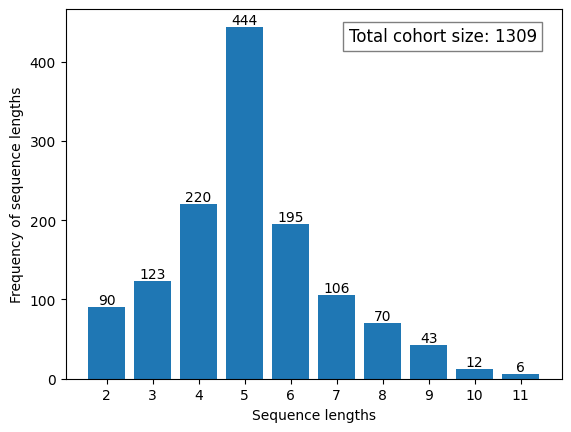

In [39]:
series = seq_lengths.sort_index()

# Plot the histogram with indices as x-ticks and values as heights
plt.bar(series.index, series.values)
plt.xlabel('Sequence lengths')
plt.ylabel('Frequency of sequence lengths')
plt.text(0.95, 0.95, f'Total cohort size: {series.sum()}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
for x, height in zip(series.index, series.values):
    plt.text(x, height, f'{height}', ha='center', va='bottom', fontsize=10)
plt.xticks(series.index)  # Set x-ticks to match the indices
plt.show()

In [46]:
sum([length*freq for (length, freq) in zip(seq_lengths.index, seq_lengths.values)])

6694

In [41]:
def core(row):
    if row['vis_info', 'RID'] in final_core_cohort_seqs.index:
        if row['vis_info', 'VISCODE'] in final_core_cohort_seqs[row['vis_info', 'RID']]:
            return True
        else:
            return False
    else:
        return False
total_cohort_final[total_cohort_final.apply(core, axis=1)]

vis_info                     main_cognitive_tests                      \
           RID        PTID VISCODE                CDRSB    ADAS11    ADAS13   
5            4  022_S_0004       0             0.058824  0.207681  0.253929   
6            4  022_S_0004       6             0.029412  0.251159  0.301548   
7            4  022_S_0004      12             0.058824  0.217391  0.261905   
8            4  022_S_0004      18             0.058824  0.294638  0.337262   
9            4  022_S_0004      36             0.058824  0.260870  0.297619   
...        ...         ...     ...                  ...       ...       ...   
12382     4320  022_S_4320      48             0.000000  0.057971  0.059524   
12386     4446  135_S_4446      48             0.029412  0.115942  0.142857   
12428     4513  041_S_4513      48             0.000000  0.028986  0.023810   
12482     4164  023_S_4164      48             0.000000  0.101449  0.190476   
12484     4115  023_S_4115      48             0.058824  0.130435  0.214286   

                                                                 ...  \
           MMSE RAVLT_immediate RAVLT_learning RAVLT_forgetting  ...   
5      0.900000        0.493333       0.631579         0.592593  ...   
6      0.933333        0.440000       0.631579         0.481481  ...   
7      0.866667        0.493333       0.473684         0.481481  ...   
8      0.900000        0.586667       0.684211         0.518519  ...   
9      0.833333        0.586667       0.631579         0.518519  ...   
...         ...             ...            ...              ...  ...   
12382  1.000000        0.413333       0.684211         0.592593  ...   
12386  0.966667        0.680000       0.526316         0.444444  ...   
12428  1.000000        0.853333       0.684211         0.555556  ...   
12482  0.966667        0.560000       0.631579         0.592593  ...   
12484  1.000000        0.520000       0.578947         0.666667  ...   

                 MRI ROI: Volume (Cortical Parcellation)  \
      Volume (Cortical Parcellation) of RightFrontalPole   
5                                               0.232725   
6                                               0.256495   
7                                               0.149807   
8                                               0.305141   
9                                               0.257601   
...                                                  ...   
12382                                           0.343284   
12386                                           0.411277   
12428                                           0.330017   
12482                                           0.298507   
12484                                           0.474295   

                                                       \
      Volume (Cortical Parcellation) of RightFusiform   
5                                            0.416415   
6                                            0.369159   
7                                            0.372249   
8                                            0.359738   
9                                            0.354763   
...                                               ...   
12382                                        0.273741   
12386                                        0.549442   
12428                                        0.534595   
12482                                        0.478670   
12484                                        0.435785   

                                                               \
      Volume (Cortical Parcellation) of RightInferiorParietal   
5                                               0.522032        
6                                               0.545427        
7                                               0.427177        
8                                               0.406085        
9                                               0.460573        
...                                                  ...       

In [37]:
file_name = f'core_{longest_valid_gap}.pkl'
file_path = os.path.join(dir_path, file_name)

with open(file_path, "wb") as file:
    pkl.dump(final_core_cohort_seqs, file=file)